In [1]:
"""

                        ~~~~ Hypothesis Testing ~~~~
                t-tests, proportion tests, chi-square tests

1. The Basics of Hypothesis Testing
 - sampling means, statistical significance, z-scores, p-values, proportion sample
 - left/right/two tail, confidence intervals, A/B tests, Type I & II errors

2. Two-sample and ANOVA tests
 - hypothesis testing workflow, t-tests, t-stats, t-distribution, paired t-tests
 - analysis of variables tests, ttest(), pairwise t-tests

3. Proportion Tests
 - one sample proportion tests, two sample proportion tests, proportions_ztest()
 - chi square tests, chi square distribution, chi square goodness of fit tests

4. Non-Parametric Tests
 - Wilcoxon signed-rank test, non parametric anova tests, unpaired t-tests
 - Wilcoxon Mann Whitney test, Kruskal Wallis test

5. ANOVA tests vs Chi-square 'tests of independence'
 - ANOVA extends t-tests to more than 2 groups,
    Chi-square extends proportions tests to more than 2 groups


"""

import pandas
import pingouin as pin
import numpy as np
from scipy.stats import (
    iqr, uniform, binom, norm, poisson, expon,
    t,
    chisquare,  # for goodness of fit
    rankdata
)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

data_folder = '../../data'
# types: A = super center, B = discount store, C = neighborhood market
df_walmart = pandas.read_csv(f'{data_folder}/walmart_sales_subset.csv', index_col=0)
df_homeless = pandas.read_csv(f'{data_folder}/homeless.csv', index_col=0)
df_amir = pandas.read_csv(f'{data_folder}/amir_deals.csv', index_col=0)
# simplify df_amir to just 100 observations
df_amir = pandas.DataFrame(df_amir[:100])
df_mph = pandas.read_csv(f'{data_folder}/mpg.csv')
df_stack_overflow = pandas.read_feather(f'{data_folder}/stack_overflow.feather')

In [2]:
display(df_stack_overflow.info())
display(df_stack_overflow.head())
len(df_stack_overflow)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261 entries, 0 to 2260
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   respondent                         2261 non-null   float64 
 1   main_branch                        2261 non-null   object  
 2   hobbyist                           2261 non-null   object  
 3   age                                2261 non-null   float64 
 4   age_1st_code                       2261 non-null   float64 
 5   age_first_code_cut                 2261 non-null   object  
 6   comp_freq                          2261 non-null   object  
 7   comp_total                         2261 non-null   float64 
 8   converted_comp                     2261 non-null   float64 
 9   country                            2261 non-null   object  
 10  currency_desc                      2261 non-null   object  
 11  currency_symbol                    2261 non

None

,respondent,main_branch,hobbyist,age,age_1st_code,age_first_code_cut,comp_freq,comp_total,converted_comp,country,...,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro,age_cat
0,36.0,"I am not primarily a developer, but I write co...",Yes,34.0,30.0,adult,Yearly,60000.0,77556.0,United Kingdom,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4.0,3.0,At least 30
1,47.0,I am a developer by profession,Yes,53.0,10.0,child,Yearly,58000.0,74970.0,United Kingdom,...,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43.0,28.0,At least 30
2,69.0,I am a developer by profession,Yes,25.0,12.0,child,Yearly,550000.0,594539.0,France,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13.0,3.0,Under 30
3,125.0,"I am not primarily a developer, but I write co...",Yes,41.0,30.0,adult,Monthly,200000.0,2000000.0,United States,...,Appropriate in length,No,None,None,None,Just as welcome now as I felt last year,40.0,11.0,11.0,At least 30
4,147.0,"I am not primarily a developer, but I write co...",No,28.0,15.0,adult,Yearly,50000.0,37816.0,Canada,...,Appropriate in length,No,"Another engineering discipline (such as civil,...",None,Express;Flask,Just as welcome now as I felt last year,40.0,5.0,3.0,Under 30


2261

# Hypothesis Tests & z-scores

1.7101640671648524

0.9563822308560407

0.04361776914395932

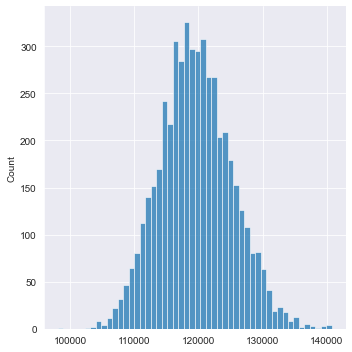

In [3]:
'''
Hypothesis: The mean salary of data scientists is 110k
 - point estimate (aka sample stat)
 - standard error is the standard deviation of the bootstrap.dist
 - z score = (orig_stat - hypothetical_stat) / standard_error
  -- the z score is the "standardized value"
 - The 'probability density function' is basically The normal distribution
  -- This is referred to as the z-distribution (which is related to the z-score)
'''
mean_salary = df_stack_overflow['converted_comp'].mean()
hypothetical_salary = 110000
stack_overflow_bootstrap_dist = []
for i in range(5000):
    stack_overflow_bootstrap_dist.append(
        np.mean(df_stack_overflow.sample(frac=1, replace=True)['converted_comp']))

standard_error = np.std(stack_overflow_bootstrap_dist, ddof=1)
z_score = (mean_salary - hypothetical_salary) / standard_error
# left-tailed alternative hypothesis (data.sci make less than average)
p_val_left = norm.cdf(z_score, loc=0, scale=1)
# right-tailed alt.hypo (data.sci make more than average)
p_val_right = 1 - norm.cdf(z_score, loc=0, scale=1)

# output
display(z_score)
display(p_val_left)
display(p_val_right)
sns.displot(data=stack_overflow_bootstrap_dist)
plt.show()

# Two-Sample & ANOVA tests

In [4]:
'''
Performing t-tests
 - t-stat
Calculating p-values from t-stats
 - t-distribution
Paired t-tests
 - ttest()
ANOVA tests
 - pairwise t-tests

Z Score:
 z = (sample_stat - population_estimate_stat) / standard_error

T Stat:
 std_err_diff = "square root of (SD1_squared / s1_size) + (SD2_squared / s2_size)"
 t = ("difference of sample stats" - "difference of population estimate stats"?) / std_err_diff
'''

# getting the t-stat of the null hypothesis from the sample
x_mean = df_stack_overflow.groupby('age_first_code_cut')['converted_comp'].mean()
x_sd = df_stack_overflow.groupby('age_first_code_cut')['converted_comp'].std()
x_count = df_stack_overflow.groupby('age_first_code_cut')['converted_comp'].count()
display(x_mean, x_sd, x_count)
numerator = (x_mean['child'] - x_mean['adult'])
denominator = np.sqrt(
    x_sd['child'] ** 2 / x_count['child'] + x_sd['adult'] ** 2 / x_count['adult'])
t_stat = numerator / denominator
t_stat

age_first_code_cut
adult    111313.311047
child    132419.570621
Name: converted_comp, dtype: float64

age_first_code_cut
adult    271546.521729
child    255585.240115
Name: converted_comp, dtype: float64

age_first_code_cut
adult    1376
child     885
Name: converted_comp, dtype: int64

1.8699313316221844

In [5]:
alpha = 0.10
deg_of_free = x_count['child'] + x_count['adult'] - 2
# right-tail test
p_val = 1 - t.cdf(t_stat, df=deg_of_free)
display(deg_of_free, t_stat, p_val)

2259

1.8699313316221844

0.030811302165157595

In [6]:
print('Reject null hypothesis?', p_val <= alpha)

Reject null hypothesis? True


In [7]:
pin.pairwise_tests(
    data=df_stack_overflow, dv='converted_comp', between='job_sat', padjust='none')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,158.564,-0.192931
1,job_sat,Slightly satisfied,Neither,False,True,-0.700752,258.204546,two-sided,0.484088,0.114,-0.068513
2,job_sat,Slightly satisfied,Very dissatisfied,False,True,-1.243665,187.153329,two-sided,0.215179,0.208,-0.145624
3,job_sat,Slightly satisfied,Slightly dissatisfied,False,True,-0.038264,569.926329,two-sided,0.969491,0.074,-0.002719
4,job_sat,Very satisfied,Neither,False,True,1.662901,328.326639,two-sided,0.097286,0.337,0.120115
5,job_sat,Very satisfied,Very dissatisfied,False,True,0.747379,221.666205,two-sided,0.455627,0.126,0.063479
6,job_sat,Very satisfied,Slightly dissatisfied,False,True,3.076222,821.303063,two-sided,0.002166,7.43,0.173247
7,job_sat,Neither,Very dissatisfied,False,True,-0.545948,321.165726,two-sided,0.585481,0.135,-0.058537
8,job_sat,Neither,Slightly dissatisfied,False,True,0.602209,367.730081,two-sided,0.547406,0.118,0.055707
9,job_sat,Very dissatisfied,Slightly dissatisfied,False,True,1.129951,247.570187,two-sided,0.259590,0.197,0.119131


In [8]:
pin.pairwise_tests(
    data=df_stack_overflow, dv='converted_comp', between='job_sat', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,0.000638,bonf,158.564,-0.192931
1,job_sat,Slightly satisfied,Neither,False,True,-0.700752,258.204546,two-sided,0.484088,1.000000,bonf,0.114,-0.068513
2,job_sat,Slightly satisfied,Very dissatisfied,False,True,-1.243665,187.153329,two-sided,0.215179,1.000000,bonf,0.208,-0.145624
3,job_sat,Slightly satisfied,Slightly dissatisfied,False,True,-0.038264,569.926329,two-sided,0.969491,1.000000,bonf,0.074,-0.002719
4,job_sat,Very satisfied,Neither,False,True,1.662901,328.326639,two-sided,0.097286,0.972864,bonf,0.337,0.120115
5,job_sat,Very satisfied,Very dissatisfied,False,True,0.747379,221.666205,two-sided,0.455627,1.000000,bonf,0.126,0.063479
6,job_sat,Very satisfied,Slightly dissatisfied,False,True,3.076222,821.303063,two-sided,0.002166,0.021659,bonf,7.43,0.173247
7,job_sat,Neither,Very dissatisfied,False,True,-0.545948,321.165726,two-sided,0.585481,1.000000,bonf,0.135,-0.058537
8,job_sat,Neither,Slightly dissatisfied,False,True,0.602209,367.730081,two-sided,0.547406,1.000000,bonf,0.118,0.055707
9,job_sat,Very dissatisfied,Slightly dissatisfied,False,True,1.129951,247.570187,two-sided,0.259590,1.000000,bonf,0.197,0.119131


# Proportions Tests

In [9]:
# Two-sample proportions test
p_hats = df_stack_overflow.groupby('age_cat')['hobbyist'].value_counts()
p_hats

age_cat      hobbyist
At least 30  Yes          812
             No           238
Under 30     Yes         1021
             No           190
Name: hobbyist, dtype: int64

In [10]:
n_hobbyists = np.array([812, 1021])
n_rows = np.array([812 + 238, 1021 + 190])
proportions_ztest(count=n_hobbyists, nobs=n_rows, alternative='two-sided')

(-4.223691463320559, 2.403330142685068e-05)

### Chi-square test of independence _viz_

job_sat                age_cat    
Very dissatisfied      Under 30       0.509434
                       At least 30    0.490566
Slightly dissatisfied  Under 30       0.532164
                       At least 30    0.467836
Neither                Under 30       0.567164
                       At least 30    0.432836
Slightly satisfied     Under 30       0.564706
                       At least 30    0.435294
Very satisfied         Under 30       0.511945
                       At least 30    0.488055
Name: age_cat, dtype: float64

age_cat,At least 30,Under 30
job_sat,,
Very dissatisfied,0.490566,0.509434
Slightly dissatisfied,0.467836,0.532164
Neither,0.432836,0.567164
Slightly satisfied,0.435294,0.564706
Very satisfied,0.488055,0.511945


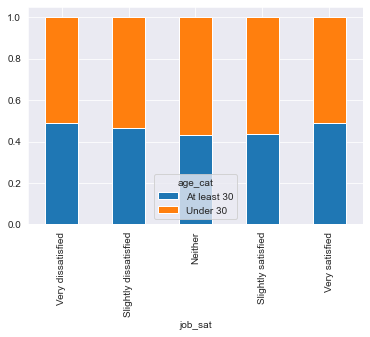

In [11]:
props = df_stack_overflow.groupby('job_sat')['age_cat'].value_counts(normalize=True)
display(props)
wide_props = props.unstack()
display(wide_props)
wide_props.plot(kind='bar', stacked=True)
plt.show()

## Chi-square test of independence

In [12]:
expected, observed, stats = pin.chi2_independence(
    data=df_stack_overflow, x='job_sat', y='age_cat')
# age categories are independent of job satisfaction
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,5.552373,4.0,0.235164,0.049555,0.437417
1,cressie-read,0.666667,5.554106,4.0,0.235014,0.049563,0.437545
2,log-likelihood,0.000000,5.558529,4.0,0.234632,0.049583,0.437871
3,freeman-tukey,-0.500000,5.562688,4.0,0.234274,0.049601,0.438178
4,mod-log-likelihood,-1.000000,5.567570,4.0,0.233854,0.049623,0.438538
5,neyman,-2.000000,5.579519,4.0,0.232828,0.049676,0.439419


In [13]:
# for chi-square goodness of fit we use scipy.stats.chisquare to hypothesize a distribution
purple_link_counts = df_stack_overflow['purple_link'].value_counts()
display(purple_link_counts)
purple_link_counts = purple_link_counts.rename_axis('purple_link').reset_index(name='n')
display(purple_link_counts)

Hello, old friend    1225
Indifferent           405
Amused                368
Annoyed               263
Name: purple_link, dtype: int64

,purple_link,n
0,"Hello, old friend",1225
1,Indifferent,405
2,Amused,368
3,Annoyed,263


In [14]:
hypothesized = pandas.DataFrame(
    {'purple_link': ['Amused', 'Annoyed', 'Hello, old friend', 'Indifferent'],
     'probs': [1 / 6, 1 / 6, 1 / 2, 1 / 6]})
n = len(df_stack_overflow)
hypothesized['n'] = hypothesized['probs'] * n
chisquare(f_obs=purple_link_counts['n'], f_exp=hypothesized['n'])

Power_divergenceResult(statistic=2459.8146837682443, pvalue=0.0)

In [16]:
df_mph.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
name             object
dtype: object

In [17]:
'some 2019 text'.find('2019')

5

In [18]:
df_mph['origin'].str.contains('s')

0       True
1       True
2       True
3       True
4       True
       ...  
393     True
394    False
395     True
396     True
397     True
Name: origin, Length: 398, dtype: bool

In [19]:
df_mph.drop_duplicates()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


In [22]:
np.random.sample([1, 2, 3, 4])

array([[[[0.00756092, 0.24329494, 0.87959222, 0.27588729],
         [0.73564309, 0.34989888, 0.90393059, 0.66734498],
         [0.0350336 , 0.11512423, 0.83280253, 0.0334732 ]],

        [[0.19285392, 0.30429392, 0.22406331, 0.7006999 ],
         [0.62185724, 0.47938533, 0.9619439 , 0.04890176],
         [0.73249802, 0.74641197, 0.06006911, 0.02113947]]]])